In [44]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import json

In [45]:
def normalize(X, radius=None):
    x_min = X.min(axis=1).min(axis=0)
    x_max = X.max(axis=1).max(axis=0)
    if radius == None:
        return (X - x_min) / (x_max - x_min)
    else:
        return (X - x_min) / (x_max - x_min), \
            radius / (np.max(x_max) - np.min(x_min))

In [46]:
data = pickle.load(open("./test/test_run.pkl", mode="rb"))

In [47]:
data.keys()

dict_keys(['velocity', 't', 'z', 'T', 'P', 'SS', 'H2SO4', 'O1D', 'O3', 'OH', 'SO2', 'BISULFATE (aq)', 'H2O (aq)', 'H2SO4 (aq)', 'N', 'pH', 'POM (aq)', 'SULFATE (aq)', 'Ddry', 'Dp', 'kappa'])

In [48]:
particle_list = ['BISULFATE (aq)', 'H2SO4 (aq)', 'pH', 'POM (aq)', 'SULFATE (aq)']

In [49]:
total_dry_mass = np.zeros_like(data[particle_list[0]])
for particle in particle_list:
    if particle == 'pH':
        Hplus = 10**-data[particle]
        total_dry_mass += Hplus
    else:
        total_dry_mass += data[particle]

In [50]:
log_dry_mass = np.log(total_dry_mass)
log_dry_mass = np.reshape(log_dry_mass, (log_dry_mass.shape[0],
                                         log_dry_mass.shape[1],
                                         1))

In [55]:
ph = np.reshape(data['pH'], (data['pH'].shape[0],
                             data['pH'].shape[1],
                             1))

In [58]:
log_N = np.reshape(np.log(data['N']), (data['N'].shape[0],
                                       data['N'].shape[1],
                                       1))

In [56]:
mass_frac_list = []
for particle in particle_list:
    if particle != 'pH':
        mass_frac_list.append(data[particle]/total_dry_mass)

In [57]:
mass_frac = np.stack(mass_frac_list, axis=-1)

In [59]:
growth_factor = (data['H2O (aq)'] + total_dry_mass )/ total_dry_mass # linear

In [60]:
gf = np.reshape(growth_factor, (growth_factor.shape[0],
                                growth_factor.shape[1],
                                1))

In [61]:
molecular_mass = {'H2SO4': 0.09808, 'O1D':0.01600, 'OH': 0.01701, 'O3': 0.04800, 'SO2': 0.064}

In [62]:
mm_keys = list(molecular_mass.keys())

In [63]:
mm_keys

['H2SO4', 'O1D', 'OH', 'O3', 'SO2']

In [64]:
gassum = np.zeros_like(data['SO2'])
gas_moles = []
for gas in mm_keys:
    gassum += data[gas]
    gas_moles.append(data[gas]/molecular_mass[gas])

In [65]:
gassum_tiled = np.tile(gassum, (1000, 1)).transpose()

In [66]:
log_gas_sum = np.log(gassum_tiled)
log_gas_sum = np.reshape(log_gas_sum, (log_gas_sum.shape[0],
                                       log_gas_sum.shape[1],
                                       1))

In [67]:
total_gas_moles = np.sum(gas_moles) 

In [69]:
moles_frac_list = []
for gas in molecular_mass.keys():
    moles = data[gas]/molecular_mass[gas]
    moles_frac = moles/total_gas_moles
    all_parts = np.tile(moles_frac, (1000, 1)).transpose()
    moles_frac_list.append(all_parts)

In [70]:
moles_frac = np.stack(moles_frac_list, axis=-1) # first time step has zeros

In [71]:
[array.shape for array in [log_dry_mass, mass_frac, ph, log_N, gf, log_gas_sum, moles_frac]]

[(3601, 1000, 1),
 (3601, 1000, 4),
 (3601, 1000, 1),
 (3601, 1000, 1),
 (3601, 1000, 1),
 (3601, 1000, 1),
 (3601, 1000, 5)]

log particle's dry mass in `chem_data[0]`

log total trace gas mass in `chem_data[1]`

log N in `chem_data[2]`

pH in `chem_data[3]` 

Growth factor in `chem_data[4]` 

BISULFATE (aq) in `chem_data[5]` 

H2SO4 (aq) in `chem_data[6]`

POM (aq) in `chem_data[7]`

SULFATE (aq) in `chem_data[8]`

H2SO4 in `chem_data[9]`

O1D in `chem_data[10]`

O3 in `chem_data[11]`

OH in `chem_data[12]`

SO2 in `chem_data[13]`

In [72]:
chem_data = np.concatenate([log_dry_mass, log_gas_sum, log_N, ph, gf, mass_frac, moles_frac], axis=-1) 

In [73]:
rad = 0.10 # it doesn't matter if knn_graph

In [74]:
norm_chem_data, radius = normalize(chem_data, rad)

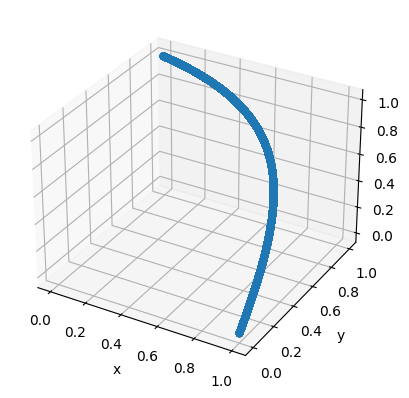

In [75]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = norm_chem_data[:,0:30,11], norm_chem_data[:,0:30,12], norm_chem_data[:,0:30,13]

ax.scatter(x, y, z)

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [76]:
train_cutoff = int(norm_chem_data.shape[1]*0.6)
#test_cutoff = int(norm_chem_data.shape[1]*0.8)

In [77]:
idxs = list(range(norm_chem_data.shape[1]))

In [78]:
from random import shuffle
shuffle(idxs)

In [79]:
train_X = norm_chem_data[:,idxs[:train_cutoff],:]
test_X = norm_chem_data[:,idxs[train_cutoff:],:]
#val_X = norm_chem_data[:,idxs[test_cutoff:],:]

In [80]:
train_vel = train_X[1:,:,:] - train_X[:-1,:,:]
train_acc = train_vel[1:,:,:] - train_vel[:-1,:,:]

In [81]:
vel_mean = list(np.max(np.mean(train_vel, axis=0), axis=0))
vel_std = list(np.max(np.std(train_vel, axis=0), axis=0))

In [82]:
acc_mean = list(np.max(np.mean(train_acc, axis=0), axis=0))
acc_std = list(np.max(np.std(train_acc, axis=0), axis=0))

In [83]:
# # in case of zeros
# vel_std = list(np.where(np.abs(vel_std) <= 1e-22, 1e-22, vel_std))
# acc_std = list(np.where(np.abs(acc_std) <= 1e-22, 1e-22, acc_std))

In [84]:
stack_min = np.min(np.min(train_X, axis=0), axis=0)
stack_max = np.max(np.max(train_X, axis=0), axis=0)
bounds = [list(t) for t in zip(stack_min, stack_max)]

In [85]:
# Data to be written
dictionary = {
    "bounds": bounds,
    "sequence_length": train_X.shape[0],
    "default_connectivity_radius": radius,
    "dim": train_X.shape[-1],
    "dt": 1,
    "vel_mean": vel_mean,
    "vel_std": vel_std,
    "acc_mean": acc_mean,
    "acc_std": acc_std
}
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open("../data/metadata.json", "w") as outfile:
    outfile.write(json_object)

In [86]:
train_X_type = np.array([1]*train_X.shape[1])
test_X_type = np.array([1]*test_X.shape[1])
#val_X_type = np.array([1]*val_X.shape[1])

In [87]:
train_pre = np.array([train_X, train_X_type], dtype="object")
test_pre = np.array([test_X, test_X_type], dtype="object")
#val_pre = np.array([val_X, val_X_type], dtype="object")

In [88]:
np.savez("../data/train.npz", x=train_pre)
np.savez("../data/test.npz", x=test_pre)
#np.savez("../data/valid.npz", x=val_pre)

In [89]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    #edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    edge_index = pyg.nn.knn_graph(recent_position, k=2)
    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"][:3])) / torch.sqrt(torch.tensor(metadata["vel_std"][:3]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"][:3])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"][:3])) / torch.sqrt(torch.tensor(metadata["acc_std"][:3]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

In [90]:
vis_sample = train_X[:,:,3:6]

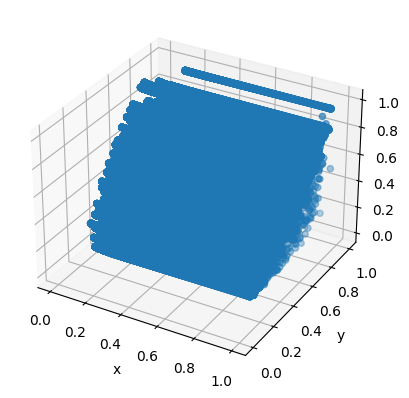

In [91]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = vis_sample[:,:,0], vis_sample[:,:,1], vis_sample[:,:,2]

ax.scatter(x, y, z)

# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [92]:
class OneStepDataset(pyg.data.Dataset):
    def __init__(self, window_length=6, noise_std=6.7e-4, return_pos=False):
        super().__init__()

        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
    
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos

        self.particle_type = train_X_type
        self.position = vis_sample

        self.dim = 3
    
        self._data_lengths = [x.shape[0] - self.window_length for x in self.position]
        self._length = sum(self._data_lengths)
        # pre-compute cumulative lengths
        # to allow fast indexing in __getitem__
        self._precompute_cumlengths = [sum(self._data_lengths[:x]) for x in range(1, len(self._data_lengths) + 1)]
        self._precompute_cumlengths = np.array(self._precompute_cumlengths, dtype=int)

    def len(self):
        return self._length

    def get(self, idx):
        # Select the trajectory immediately before
        # the one that exceeds the idx
        # (i.e., the one in which idx resides).
        trajectory_idx = np.searchsorted(self._precompute_cumlengths - 1, idx, side="left")

        # Compute index of pick along time-dimension of trajectory.
        start_of_selected_trajectory = self._precompute_cumlengths[trajectory_idx - 1] if trajectory_idx != 0 else 0
        time_idx = self.window_length + (idx - start_of_selected_trajectory)

        # Prepare training data.
        position_seq = self.position[time_idx - self.window_length:time_idx]
        position_seq = position_seq.transpose(1, 0, 2)
        
        particle_type = np.full(position_seq.shape[0], self.particle_type, dtype=int)
        
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)
        
        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
          return graph, position_seq[:, -1]
        return graph

The first item in the valid set is a graph: Data(x=[600], edge_index=[2, 1200], edge_attr=[1200, 4], y=[600, 3], pos=[600, 18])
This graph has 600 nodes and 1200 edges.
Each node is a particle and each edge is the interaction between two particles.
Each node has 1 categorial feature (Data.x), which represents the type of the node.
Each node has a 18-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.
Each edge has a 4-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.
The model is expected to predict a 3-dim vector for each node (Data.y), which represents the acceleration of the particle.
tensor([[0.9557, 0.4683],
        [0.9410, 0.4538],
        [0.9712, 0.5931],
        ...,
        [0.9524, 0.4600],
        [0.9720, 0.5384],
        [0.9747, 0.5551]], dtype=torch.float64)


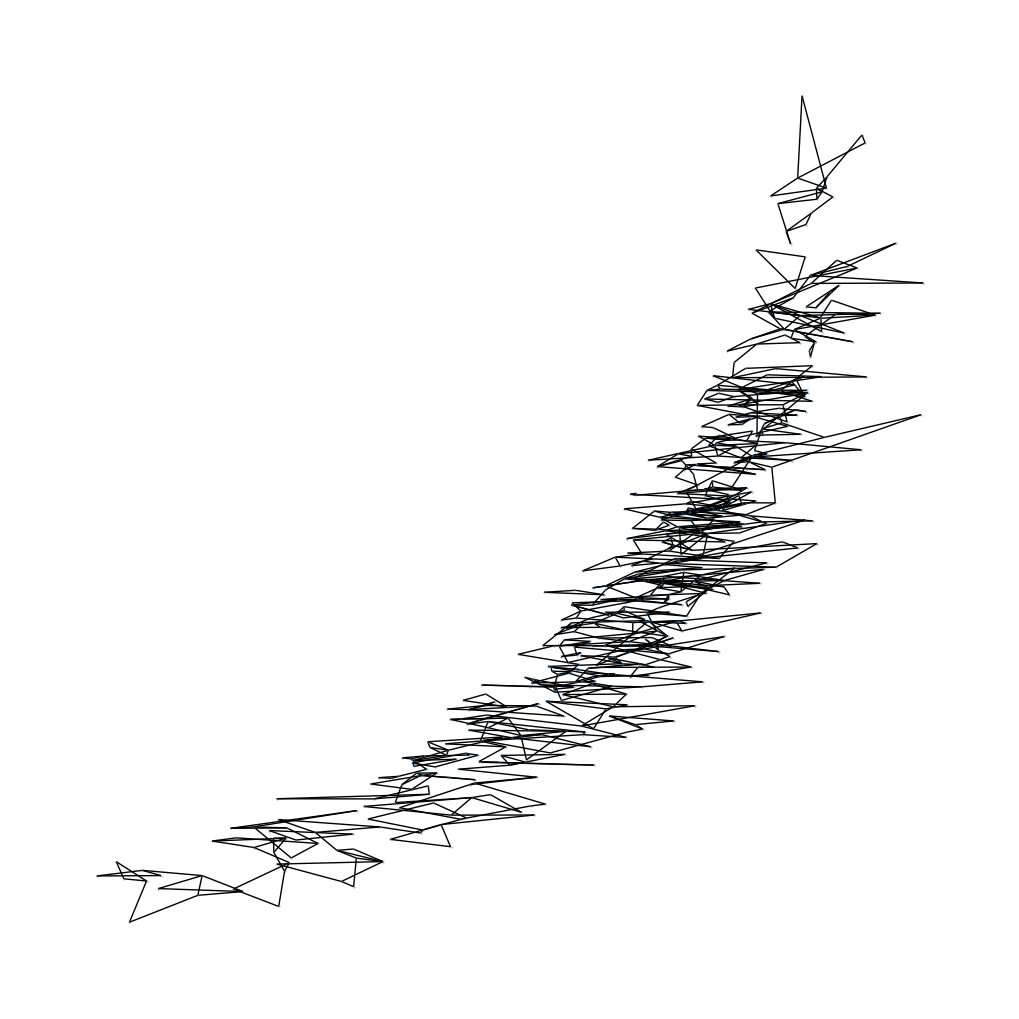

In [93]:
%matplotlib inline
import os
import torch
import matplotlib.pyplot as plt
import networkx as nx

data_path = "../data/"
dataset_sample = OneStepDataset(return_pos=True)
graph, position = dataset_sample[0]

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")
print(position[:,:2])
# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(10, 10))
nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position[:,:2])}, node_size=0.1)
plt.savefig("graph.png", dpi=500)
plt.show()

In [11]:
rollout_data = pickle.load(open("../output/rollout_ex0.pkl", "rb"))

In [4]:
type(rollout_data)

dict

In [5]:
rollout_data.keys()

dict_keys(['initial_positions', 'predicted_rollout', 'ground_truth_rollout', 'particle_types', 'material_property', 'metadata', 'loss'])

In [12]:
true_x = rollout_data['ground_truth_rollout']

In [13]:
pred_x = rollout_data['predicted_rollout']

In [14]:
data_names = ['Dry Mass', 'Trace Gas Mass', 'Growth Factor', 
                 'BISULFATE (aq)', 'H2SO4 (aq)', 'N', 'pH', 
                 'POM (aq)', 'SULFATE (aq)', 'H2SO4', 'O1D', 'O3', 'OH', 'SO2']

In [9]:
for i in range(true_x.shape[-1]):
    for j in range(i+1, true_x.shape[-1]):
        plt.figure(figsize=(10, 10))
        plt.scatter(pred_x[:,:,i], pred_x[:,:,j], s=0.1)
        plt.scatter(true_x[:,:,i], true_x[:,:,j], s=0.1, alpha=0.3)
        plt.xscale('log'); plt.yscale('log');
        plt.xlabel(data_names[i]); plt.ylabel(data_names[j])
        plt.savefig(f"../figures/{data_names[i]}-{data_names[j]}.png")
        plt.close()

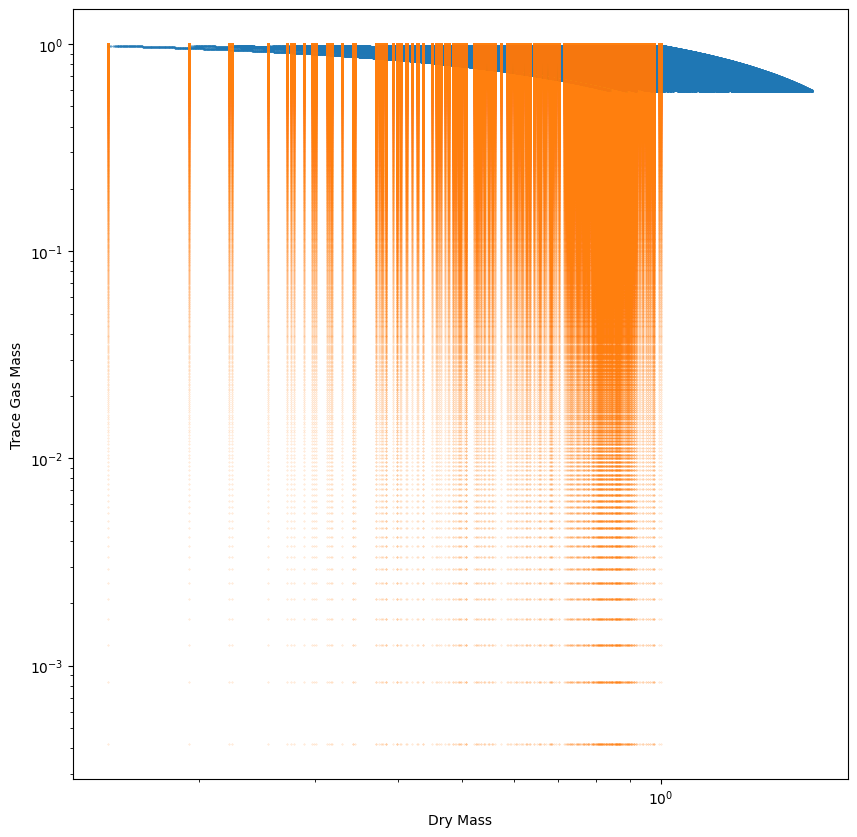

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(pred_x[:,:,0], pred_x[:,:,1], s=0.1)
plt.scatter(true_x[:,:,0], true_x[:,:,1], s=0.1, alpha=0.3)
plt.xscale('log'); plt.yscale('log');
plt.xlabel(data_names[0]); plt.ylabel(data_names[1])
plt.show()